In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
import time
import pandas as pd

In [2]:
allNs = [int(np.ceil(i)) for i in np.geomspace(13, 150, 30)]
meanerror_Gyxz = []
meanerror_dxGyxz = []
meanerror_3R = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
timelog = []
meanerror_B2vsE2 = []
meanerror_E2vsB2 = []
for N in allNs:
    start_time = time.time()
    L = 20
    dx = L/N
    FD = FD_file.FD_Class(dx, periodic_boundary=False)#, order6=True)
    ic = 2*FD.mask
    xyz = np.arange(-L/2, L/2, dx)[:N]
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    del xyz, y, z
    Box_zero = np.zeros([N, N, N])
    Box_ones = np.ones([N, N, N])
    
    t = 1.5

    r = 1/2
    b = np.sqrt(4*r*(1-r))
    beta = 0.0
    A = 1.0
    B = b*(x+np.log(t))
    C = 0.0
    gdown = np.array([[(t**2)*Box_ones, Box_zero, Box_zero],
                      [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))],
                      [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))]])
    gdown4 = np.array([[-Box_ones, Box_zero, Box_zero, Box_zero],
                       [Box_zero, gdown[0,0], gdown[0,1], gdown[0,2]],
                       [Box_zero, gdown[1,0], gdown[1,1], gdown[1,2]],
                       [Box_zero, gdown[2,0], gdown[2,1], gdown[2,2]]])
    del gdown
    

    dtA = 0.0
    dtB = b/t
    dtC = 0.0
    Kdown = (-1/2)*np.array([[2*t*Box_ones, Box_zero, Box_zero],
                             [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*A*dtA*np.exp(beta)+2*C*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta))],
                             [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*B*dtB*np.exp(beta)+2*A*dtA*np.exp(-beta))]])
    del B
    gup = RRead.inv3(gdown4[1:,1:])

    RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
    Gudd = RCW.Christoffel_symbol(gdown4[1:,1:], gup)
    
    nup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])
    del Box_zero, Box_ones
    Bdict = RCW.Weyl_B(gdown4, nup, gup, Gudd, Kdown)
    B2th = 1/(2*(t**4))
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(Bdict['B2']/B2th - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(Bdict['Btrace'])[ic:-ic,ic:-ic,ic:-ic]))]
    B2 = Bdict['B2']
    del Bdict, B2th, nup
    
    Gyxz = Gudd[1,0,2]
    Gyxzth = (1-np.log(t)*np.log(t)-2*np.log(t)*x-x*x)/2
    meanerror_Gyxz += [np.mean(np.ma.masked_invalid(abs(Gyxz/Gyxzth - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    
    dxGyxz = FD.D3x(Gudd[1,0,2])
    dxGyxzth = (-2*np.log(t)-2*x)/2
    meanerror_dxGyxz += [np.mean(np.ma.masked_invalid(abs(dxGyxz/dxGyxzth - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    del x, Gyxz, Gyxzth, dxGyxz, dxGyxzth
    
    RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)
    del Gudd
    RicciS3th = -2/(t*t)
    meanerror_3R += [np.mean(np.ma.masked_invalid(abs(RicciS3/RicciS3th-1)[ic:-ic,ic:-ic,ic:-ic]))]
    
    G        = 1
    kappa    = 8*np.pi*G
    rho      = 0
    pressure = 0
    uup = np.array([np.ones([N, N, N]), np.zeros([N, N, N]), np.zeros([N, N, N]), np.zeros([N, N, N])])
    udown = np.einsum('ab...,b...->a...', gdown4, uup)
    Tdown4 = (rho+pressure)*np.einsum('a...,b...->ab...',udown,udown)+pressure*gdown4
    Tdown3 = Tdown4[1:,1:]
    del udown, uup, Tdown4
    
    Edict = RCW.Weyl_E(gdown4[1:,1:], gup, RicciS3, RicciTdown, Kdown, kappa, rho, 0.0, Tdown3)
    E2th = 1/(2*(t**4))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(Edict['E2']/E2th - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(Edict['Etrace'])[ic:-ic,ic:-ic,ic:-ic]))]
    E2 = Edict['E2']
    del Edict, RicciS3, RicciTdown, E2th, Tdown3, gup, Kdown, gdown4
    
    meanerror_B2vsE2 += [np.mean(np.ma.masked_invalid(abs(B2/E2 - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    meanerror_E2vsB2 += [np.mean(np.ma.masked_invalid(abs(E2/B2 - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    del B2, E2
    timelog += [(time.time() - start_time)/60]
    print('N={}, T={:.5f}, error={:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2e}'.format(N, timelog[-1], meanerror_3R[-1], meanerror_B2[-1], meanerror_BT[-1], meanerror_E2[-1], meanerror_ET[-1]))


N=13, T=0.00448, error=4.23e+00, 1.35e+01, 1.16e-15, 5.01e+02, 9.55e-16
N=15, T=0.00595, error=2.52e+00, 3.36e+00, 5.35e-16, 3.03e+01, 2.04e-15
N=16, T=0.00708, error=1.94e+00, 1.84e+00, 4.39e-16, 8.03e+00, 2.36e-15
N=17, T=0.00844, error=1.51e+00, 1.06e+00, 5.30e-16, 1.62e+00, 1.57e-15
N=19, T=0.01136, error=9.43e-01, 3.96e-01, 8.55e-16, 8.70e-01, 1.62e-15
N=20, T=0.01321, error=7.58e-01, 2.54e-01, 1.61e-15, 9.72e-01, 8.28e-16
N=22, T=0.01738, error=5.06e-01, 1.13e-01, 1.07e-15, 8.27e-01, 1.72e-15
N=24, T=0.02203, error=3.50e-01, 5.50e-02, 1.17e-15, 6.29e-01, 1.72e-15
N=26, T=0.02712, error=2.50e-01, 2.87e-02, 1.82e-15, 4.72e-01, 2.17e-15
N=28, T=0.03415, error=1.83e-01, 1.59e-02, 1.79e-15, 3.56e-01, 1.86e-15
N=31, T=0.04570, error=1.20e-01, 7.18e-03, 2.46e-15, 2.39e-01, 2.98e-15
N=33, T=0.05524, error=9.24e-02, 4.45e-03, 1.83e-15, 1.87e-01, 2.66e-15
N=36, T=0.07003, error=6.45e-02, 2.31e-03, 1.95e-15, 1.32e-01, 2.95e-15
N=39, T=0.08641, error=4.64e-02, 1.27e-03, 2.54e-15, 9.55e-02, 2

In [3]:
data = np.array([allNs[:len(timelog)], timelog]).T
columns = ['N', 'Time']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/PlaneWave_Slicing_Time.csv')

In [4]:
data = np.array([allNs, meanerror_Gyxz, meanerror_dxGyxz, meanerror_3R, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', 'Gyxz', 'dxGyxz', '3R', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/PlaneWave_Slicing.csv')

In [5]:
data = np.array([allNs, meanerror_B2vsE2, meanerror_E2vsB2]).T
columns = ['N', 'B2/E2-1', 'E2/B2-1']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/PlaneWave_Slicing_B2vsE2.csv')

<IPython.core.display.Javascript object>


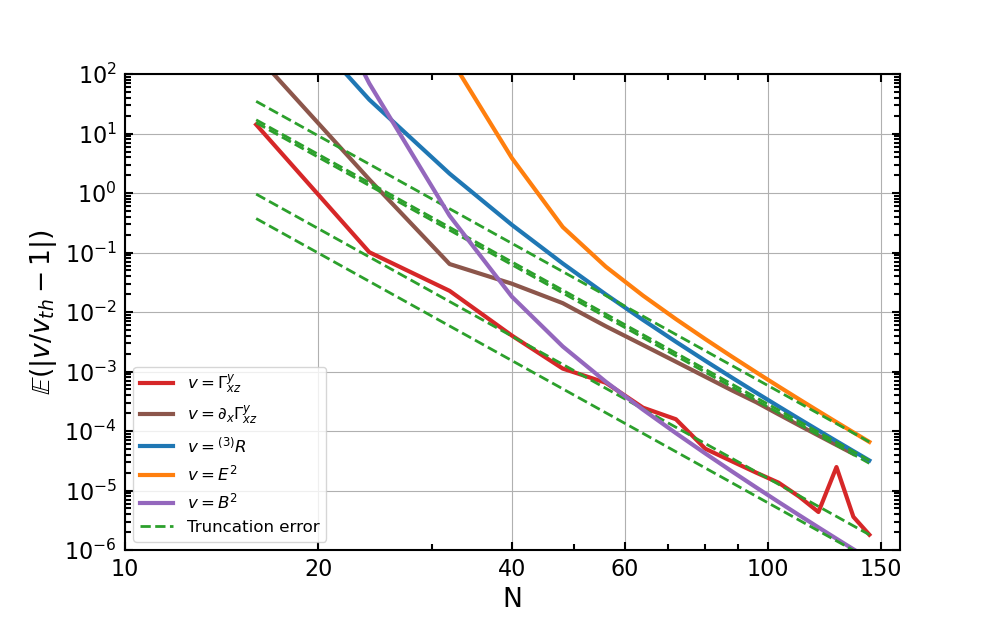

Text(0, 0.5, '$\\mathbb{E}\\left(|v/v_{th}-1|\\right)$')

In [6]:
idec = -1


phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
lw = 2

plt.loglog(allNs, meanerror_Gyxz, 'C3', label=r'$v=\Gamma^{y}_{xz}$')
yplot_4th_order_decrease = [meanerror_Gyxz[-1]*((allNs[idec]/N)**6) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=lw)

plt.loglog(allNs[:-1], meanerror_dxGyxz[:-1], 'C5', label=r'$v=\partial_{x}\Gamma^{y}_{xz}$')
yplot_4th_order_decrease = [meanerror_dxGyxz[-3]*((allNs[-3]/N)**6) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=lw)

plt.loglog(allNs, meanerror_3R, 'C0', label=r'$v={}^{(3)}R$')
yplot_4th_order_decrease = [meanerror_3R[idec]*((allNs[idec]/N)**6) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=lw)

plt.loglog(allNs, meanerror_E2, 'C1', label=r'$v=E^2$')
yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**6) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=lw)

plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**6) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', label='Truncation error', linewidth=lw)

plt.legend(loc=3, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.ylim(1e-6, 1e2)
plt.xticks([10, 20,40,60,100,150], ['10','20','40','60','100','150'])
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
#plt.savefig('Plots/PlaneWave_Slicing.pdf')